In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from pywave.energy_transport.energy_transfer_2dirns import EnergyTransfer2Dirns

In [2]:
def init_shape(x, x0=15, shape="step"):
    if shape == "gaussian":
        std = 4
        return np.exp(-pow((x-x0)/std, 2)/2)

    #step
    out = np.ones_like(x)
    out[x<x0-10] = 0
    out[x>x0+10] = 0
    return out

In [3]:
def plot_step(x, u, v, c, alpha, gamma, n, dt, outdir=None, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, u, '--')
    t = n * dt
    exact = init_shape(x - c * t, **kwargs) * np.exp(-(alpha+gamma)*t)
    ax.plot(x, exact, 'r')
    ax.set_title(f't = {t}s')
    ax.set_xlabel('x, m')
    ax.set_ylabel('c')
    if outdir is None: return
    figname = '%s/adv%2.2i.png' %(outdir, n)
#     print(f'Saving {figname}')
    fig.savefig(figname)

In [4]:
def run(et, u0, v0, c, alpha, gamma, x, outdir=None, **kwargs):
    if outdir is not None:
        print(f'Saving figs in {outdir}')
        os.makedirs(outdir, exist_ok=True)
    #plot initial conditions
    plot_step(x, u0, v0, c, alpha, gamma, 0,  et.dt, outdir=outdir, **kwargs)
    u = np.copy(u0)
    v = np.copy(v0)
    for n in range(50):
        plt.close()
        u, v = et.step(u, v, c, alpha, gamma)
        plot_step(x, u, v, c, alpha, gamma, n+1,  et.dt, outdir=outdir, **kwargs)

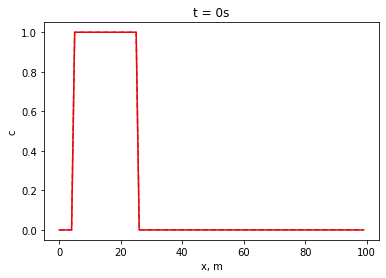

In [5]:
cfl = .9
dx = 1
dt = 1
alpha = .1
gamma = .1
c, x0 = cfl*dx/dt, 15 # advect left to right
# c, x0 = -cfl*dx/dt, 85 # advect right to left
x = np.arange(100)*dx
shape = "step"
# shape = "gaussian"
kw_init=dict(shape=shape, x0=x0)
u0 = init_shape(x, **kw_init)
v0 = np.zeros_like(u0)
plot_step(x, u0, v0, c, alpha, gamma, 0,  dt, **kw_init)

Saving figs in et_fou


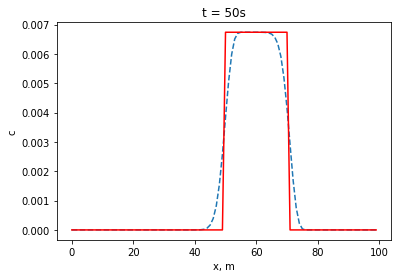

In [6]:
gamma = 0
uss = np.array([[-1,0],[0,0]])# simple model: u attenuated, no E transferred to v
et = EnergyTransfer2Dirns(dx, dt,
                            unit_scat_source=uss,
                            scheme='first_order_upwind',
                            u_correction_scheme="split_step",
                         )
run(et, u0, v0, c, alpha, gamma, x, outdir='et_fou', **kw_init)

Saving figs in et_fou_iso


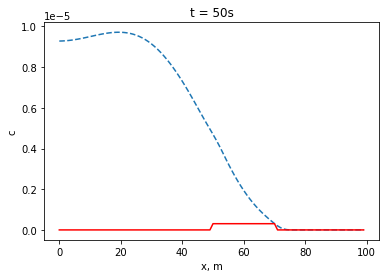

In [7]:
# isotropic
alpha = .1
gamma = 0.2
et = EnergyTransfer2Dirns(dx, dt,
                            aniso=False,
                            scheme='first_order_upwind',
                            u_correction_scheme="split_step",
                         )
run(et, u0, v0, c, alpha, gamma, x, outdir='et_fou_iso', **kw_init)

Saving figs in figs_lw


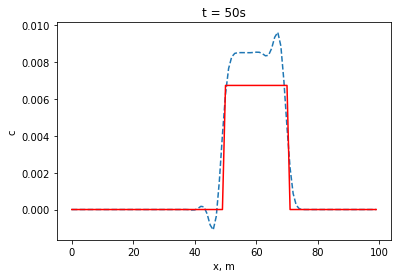

In [8]:
adv = AdvectAtten1D(dx, dt, scheme='lax_wendroff',
                    flux_correction_scheme=None,
                    u_correction_scheme="implicit")
run(adv, u0, c, alpha, x, outdir="figs_lw", **kw_init)

Saving figs in figs_lw_vl


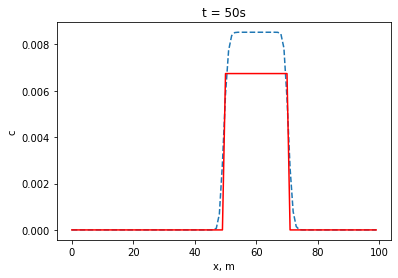

In [9]:
adv = AdvectAtten1D(dx, dt, scheme='lax_wendroff',
                    limiter='van_leer',
                    flux_correction_scheme=None,
                    u_correction_scheme="implicit",
                   )
run(adv, u0, c, alpha, x, outdir="figs_lw_vl", **kw_init)

In [1]:
adv = AdvectAtten1D(dx, dt, scheme='lax_wendroff',
                    limiter='superbee',
                    flux_correction_scheme=None,
                    u_correction_scheme="implicit",
                   )
run(adv, u0, c, alpha, x, outdir= 'figs_lw_sb', **kw_init)

NameError: name 'AdvectAtten1D' is not defined